In [ ]:
!pip install transformers
!pip install pandas
!pip install sklearn
!pip install torch
!pip install sentencepiece
!pip install sacremoses
!pip install importlib_metadata
!pip install tabulate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 116.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 53.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post5-py3-none-any.whl size=2950 sha256=c8ef625e430219d90ebb136abbde6ec8c3983558cdbd9e8d98534ad55f79d11c
  Stored in directory: /root/.cache/pip/wheels/38/1f/8d/4f812c590e074c1e928f5cec67bf5053b71f38e2648739403a
Successfully built sklearn
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.o

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import os
import zipfile
import uuid
import string
import re
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from sklearn.model_selection import train_test_split
from tabulate import tabulate
import random

learning_rates = [1e-4, 1e-6]
batch_sizes = [1, 4]
num_epochs = 2
model_size = 'gpt2'

def clean_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    text = text.strip()
    return text

def load_csv_file(path, column_name):
    df = pd.read_csv(path)
    df = df[[column_name]]
    df.columns = ['text']
    df['text'] = df['text'].apply(clean_text)
    return df

def load_text_files_from_zip(zip_path):
    data = []
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for member in zip_ref.namelist():
            if member.endswith('.txt'):
                unique_id = uuid.uuid4()
                temp_dir = 'temp_dir'
                os.makedirs(temp_dir, exist_ok=True)
                new_filename = f'{temp_dir}/{unique_id}.txt'
                with open(new_filename, 'w') as f:
                    try:
                        text = zip_ref.read(member).decode('utf-8')
                        f.write(text)
                        data.append(clean_text(text))
                    except:
                        pass
    return pd.DataFrame(data, columns=['text'])

def fine_tune_and_calculate_perplexity(model, tokenizer, df_train, df_val, df_philosophy, df_poetry, df_news, learning_rate, batch_size):
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

    texts = df_train['text'].tolist()
    batches = [texts[i:i+batch_size] for i in range(0, len(texts), batch_size)]
    random_batches = random.sample(batches, 50)

    for epoch in range(num_epochs):
        for i, batch in enumerate(random_batches):
            inputs = tokenizer(batch, return_tensors='pt', truncation=True, padding=True).to(device)
            optimizer.zero_grad()
            outputs = model(**inputs, labels=inputs["input_ids"])
            loss = outputs.loss
            loss.backward()
            optimizer.step()
        print(f"Epoch: {epoch + 1}/{num_epochs}, Batch: {i + 1}/{len(random_batches)}, Loss: {loss.item():.4f}")

        torch.cuda.empty_cache()

    perplexity_philosophy = calculate_perplexity_in_batches(model, tokenizer, df_philosophy['text'].tolist(), batch_size=batch_size)
    perplexity_poetry = calculate_perplexity_in_batches(model, tokenizer, df_poetry['text'].tolist(), batch_size=batch_size)
    perplexity_news = calculate_perplexity_in_batches(model, tokenizer, df_news['text'].tolist(), batch_size=batch_size)
    perplexity_combined = calculate_perplexity_in_batches(model, tokenizer, df_all['text'].tolist(), batch_size=batch_size)  # Perplexity on combined dataset

    model = GPT2LMHeadModel.from_pretrained(model_name)
    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    model.gradient_checkpointing = True

    return perplexity_philosophy, perplexity_poetry, perplexity_news, perplexity_combined

def calculate_perplexity_in_batches(model, tokenizer, texts, batch_size):
    total_loss = 0
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    batches = [texts[i:i+batch_size] for i in range(0, len(texts), batch_size)]
    random_batches = random.sample(batches, 50)

    for i, batch in enumerate(random_batches):
        inputs = tokenizer(batch, return_tensors='pt', truncation=True, padding=True).to(device)
        optimizer.zero_grad()
        outputs = model(**inputs, labels=inputs["input_ids"])
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        del inputs
        del outputs
        del loss
        torch.cuda.empty_cache()

    average_loss = total_loss / len(random_batches)
    perplexity = torch.exp(torch.tensor(average_loss))
    return perplexity

df_philosophy = load_csv_file('/content/drive/My Drive/cse493g1/research/philosophy_data.csv', 'sentence_str')
df_poetry = load_text_files_from_zip('/content/drive/My Drive/cse493g1/research/poetry.zip')
df_news = load_text_files_from_zip('/content/drive/My Drive/cse493g1/research/bbc-news.zip')

df_train_philosophy, df_val_philosophy = train_test_split(df_philosophy, test_size=0.2, random_state=42)
df_train_poetry, df_val_poetry = train_test_split(df_poetry, test_size=0.2, random_state=42)
df_train_news, df_val_news = train_test_split(df_news, test_size=0.2, random_state=42)

df_all = pd.concat([df_train_philosophy, df_train_poetry, df_train_news], ignore_index=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = model_size
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)
model.to(device)
model.gradient_checkpointing = True

special_tokens_dict = {'pad_token': '<PAD>', 'bos_token': '<BOS>', 'eos_token': '<EOS>'}
num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)
model.resize_token_embeddings(len(tokenizer))

results = pd.DataFrame(columns=['Philosophy', 'Poetry', 'News', 'General/Combined'])

for learning_rate in learning_rates:
    for batch_size in batch_sizes:
        df_philosophy_perplexity, df_poetry_perplexity, df_news_perplexity, df_combined_perplexity = calculate_perplexity_in_batches(model, tokenizer, df_philosophy['text'].tolist(), batch_size=batch_size), calculate_perplexity_in_batches(model, tokenizer, df_poetry['text'].tolist(), batch_size=batch_size), calculate_perplexity_in_batches(model, tokenizer, df_news['text'].tolist(), batch_size=batch_size), calculate_perplexity_in_batches(model, tokenizer, df_all['text'].tolist(), batch_size=batch_size)
        results.loc[f'Pre-Trained GPT-2 (LR={learning_rate}, Batch={batch_size})'] = [df_philosophy_perplexity.item(), df_poetry_perplexity.item(), df_news_perplexity.item(), df_combined_perplexity.item()]

        perplexity_philosophy, perplexity_poetry, perplexity_news, perplexity_combined = fine_tune_and_calculate_perplexity(model, tokenizer, df_train_philosophy, df_val_philosophy, df_philosophy, df_poetry, df_news, learning_rate, batch_size)
        results.loc[f'Fine-tuned on Philosophy (LR={learning_rate}, Batch_Size={batch_size})'] = [perplexity_philosophy.item(), perplexity_poetry.item(), perplexity_news.item(), perplexity_combined.item()]
        perplexity_philosophy, perplexity_poetry, perplexity_news, perplexity_combined = fine_tune_and_calculate_perplexity(model, tokenizer, df_train_poetry, df_val_poetry, df_philosophy, df_poetry, df_news, learning_rate, batch_size)
        results.loc[f'Fine-tuned on Poetry (LR={learning_rate}, Batch_Size={batch_size})'] = [perplexity_philosophy.item(), perplexity_poetry.item(), perplexity_news.item(), perplexity_combined.item()]
        perplexity_philosophy, perplexity_poetry, perplexity_news, perplexity_combined = fine_tune_and_calculate_perplexity(model, tokenizer, df_train_news, df_val_news, df_philosophy, df_poetry, df_news, learning_rate, batch_size)
        results.loc[f'Fine-tuned on News (LR={learning_rate}, Batch_Size={batch_size})'] = [perplexity_philosophy.item(), perplexity_poetry.item(), perplexity_news.item(), perplexity_combined.item()]

        print(tabulate(results, headers='keys', tablefmt='psql'))
        print("\n")

    results = pd.DataFrame(columns=['Philosophy', 'Poetry', 'News', 'General/Combined'])

Epoch: 1/2, Batch: 50/50, Loss: 5.7711
Epoch: 2/2, Batch: 50/50, Loss: 1.6833
Epoch: 1/2, Batch: 50/50, Loss: 4.9249
Epoch: 2/2, Batch: 50/50, Loss: 3.6304
Epoch: 1/2, Batch: 50/50, Loss: 5.0507
Epoch: 2/2, Batch: 50/50, Loss: 3.6098
+----------------------------------------------------+--------------+----------+---------+--------------------+
|                                                    |   Philosophy |   Poetry |    News |   General/Combined |
|----------------------------------------------------+--------------+----------+---------+--------------------|
| Pre-Trained GPT-2 (LR=0.0001, Batch=1)             |   266759     | 140.476  | 76.4258 |            143.641 |
| Fine-tuned on Philosophy (LR=0.0001, Batch_Size=1) |      177.327 |  91.8345 | 70.8937 |            155.136 |
| Fine-tuned on Poetry (LR=0.0001, Batch_Size=1)     |      207.563 |  66.9187 | 62.8826 |            105.229 |
| Fine-tuned on News (LR=0.0001, Batch_Size=1)       |      161.256 |  69.2892 | 48.1081 |    

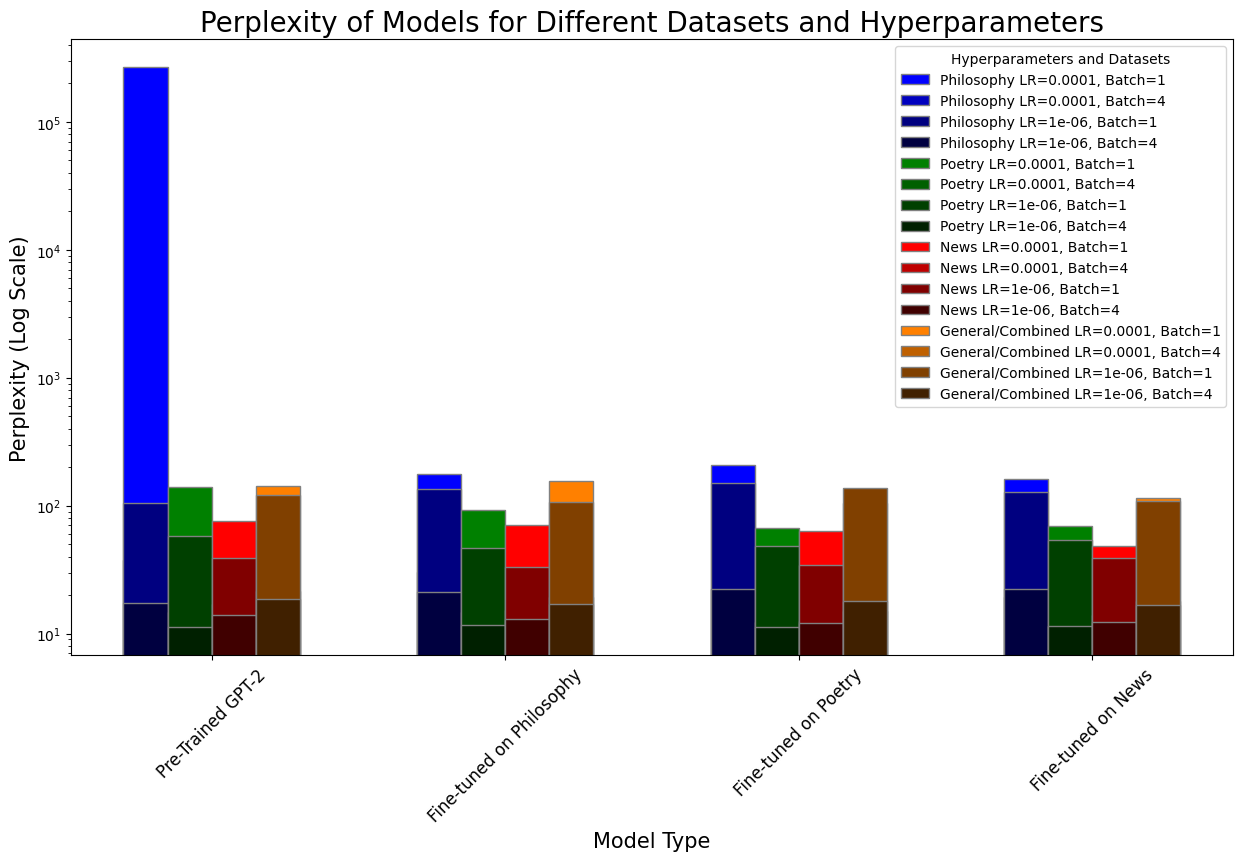

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data = {
    'Model_Type': ['Pre-Trained GPT-2', 'Fine-tuned on Philosophy', 'Fine-tuned on Poetry', 'Fine-tuned on News']*4,
    'Hyperparameters': ['LR=0.0001, Batch=1']*4 + ['LR=0.0001, Batch=4']*4 + ['LR=1e-06, Batch=1']*4 + ['LR=1e-06, Batch=4']*4,
    'Philosophy': [266759, 177.327, 207.563, 161.256, 37.5794, 30.3789, 22.1961, 19.2385, 105.067, 136.209, 151.012, 127.942, 17.4166, 21.1521, 22.3795, 22.2746],
    'Poetry': [140.476, 91.8345, 66.9187, 69.2892, 14.6156, 14.7643, 12.3031, 11.4868, 57.7883, 46.718, 48.5388, 53.593, 11.1612, 11.6507, 11.3494, 11.5398],
    'News': [76.4258, 70.8937, 62.8826, 48.1081, 17.176, 15.4015, 12.6058, 13.8589, 38.9723, 33.1278, 34.2373, 39.017, 13.9566, 13.108, 12.0412, 12.2831],
    'General/Combined': [143.641, 155.136, 105.229, 114.83, 21.3738, 19.2075, 15.0218, 18.0278, 122.197, 106.485, 137.443, 108.368, 18.7519, 16.9909, 18.1343, 16.7481]
}
df = pd.DataFrame(data)
fig, ax = plt.subplots(figsize=(15, 8))
ax.set_yscale('log')
dataset_colors = [(0, 0, 1), (0, 0.5, 0), (1, 0, 0), (1, 0.5, 0)]
color_shades = [1.0, 0.75, 0.5, 0.25]

bar_spacing = 0.0

title_font_size = 20
label_font_size = 15
ticks_font_size = 12
legend_font_size = 10

for i, dataset in enumerate(datasets):
    bar_positions = index + i*bar_width + i*bar_spacing
    values = [df[(df['Model_Type']==model_type) & (df['Hyperparameters']==hyperparameters)][dataset].values[0] 
              for model_type in model_types for hyperparameters in df['Hyperparameters'].unique()]
    values = np.array(values).reshape(len(model_types), -1)
    
    for j in range(values.shape[1]):
        color = tuple(x*color_shades[j] for x in dataset_colors[i])  # Create a shade of the base color
        ax.bar(bar_positions, values[:, j], bar_width, color=color, edgecolor='gray', label=f'{dataset} {df["Hyperparameters"].unique()[j]}')

ax.set_xticks(index + (bar_width+bar_spacing)*len(datasets)/2 - (bar_width+bar_spacing)/2)
ax.set_xticklabels(model_types, rotation=45, fontsize=ticks_font_size)

plt.xlabel('Model Type', fontsize=label_font_size)
plt.ylabel('Perplexity (Log Scale)', fontsize=label_font_size)
plt.title('Perplexity of Models for Different Datasets and Hyperparameters', fontsize=title_font_size)
handles, labels = ax.get_legend_handles_labels()

by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title='Hyperparameters and Datasets', fontsize=legend_font_size, title_fontsize=legend_font_size, loc='upper right')

plt.show()